# anoGAN

In [59]:
from __future__ import print_function
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
#from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Input, Reshape, UpSampling2D, Conv2D
import tensorflow as tf

In [60]:
import os
os.chdir('your dir')
os.makedirs('pict', exist_ok=True)
os.makedirs('weight', exist_ok=True)
# make 'pict' and 'weight' folder 

# use mnist data

In [61]:
# mnist data (28, 28, 1)
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

# noise vector dim
z_dim = 100

In [62]:
# DCGAN as reference

def build_generator(z_dim):

    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))

    return model

In [63]:
# DCGAN as reference

def build_discriminator(img_shape):

    model = Sequential()
    model.add(Conv2D(32,kernel_size=3,strides=2,input_shape=img_shape,padding='same'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(64,kernel_size=3,strides=2,input_shape=img_shape,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2D(128,kernel_size=3,strides=2,input_shape=img_shape,padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [64]:
def build_gan(generator, discriminator):

    model = Sequential()
    model.add(generator)
    model.add(discriminator)

    return model

In [65]:
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])

In [66]:
generator = build_generator(z_dim)

In [67]:
discriminator.trainable = False

In [68]:
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [69]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval,X_train,z_dim):
    # Labels
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):

        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        z = np.random.normal(0, 1, (batch_size, z_dim))
        gen_imgs = generator.predict(z)

        g_loss = gan.train_on_batch(z, real)

        if (iteration + 1) % sample_interval == 0:

            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" %(iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            sample_images(generator)
            #fig = sample_images(generator)
            #fig.savefig('pict/'+str(iteration+1)+'_img.png')
            plt.savefig('pict/'+str(iteration+1)+'_img.png')
            
            print(iteration+1)
            generator.save_weights('weight/'+str(iteration+1)+'_generator.h5', True)
            discriminator.save_weights('weight/'+str(iteration+1)+'_discriminator.h5', True)
            

In [70]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    gen_imgs = generator.predict(z)

    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(image_grid_rows,image_grid_columns,figsize=(4, 4),sharey=True,sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1

# load data

In [71]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train / 127.5 - 1.0
X_train = np.expand_dims(X_train, axis=3)

X_test = X_test / 127.5 - 1.0
X_test = np.expand_dims(X_test, axis=3)

In [72]:
normal_data = X_train[y_train==1]

normal_test_data = X_test[y_test==1]
abnormal_test_data = X_test[y_test==9]

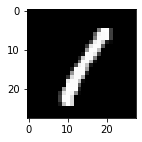

In [73]:
plt.figure(figsize=(2, 2))
plt.imshow(normal_data[0].reshape(28, 28),cmap=plt.cm.gray)
plt.show()

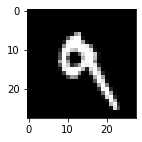

In [74]:
plt.figure(figsize=(2, 2))
plt.imshow(abnormal_test_data[0].reshape(28, 28),cmap=plt.cm.gray)
plt.show()

# train DCGAN

In [75]:
losses = []
accuracies = []
iteration_checkpoints = []

In [39]:
iterations = 30000
batch_size = 128
sample_interval = 1000

50 [D loss: 0.118081, acc.: 98.05%] [G loss: 2.531787]
50
100 [D loss: 0.090021, acc.: 97.27%] [G loss: 1.464459]
100
150 [D loss: 0.101151, acc.: 98.44%] [G loss: 2.022949]
150
200 [D loss: 0.200496, acc.: 94.53%] [G loss: 1.903812]
200
250 [D loss: 0.061035, acc.: 98.44%] [G loss: 2.920675]
250
300 [D loss: 0.155269, acc.: 95.70%] [G loss: 3.285647]
300
350 [D loss: 0.148677, acc.: 94.92%] [G loss: 1.184103]
350
400 [D loss: 0.057875, acc.: 99.22%] [G loss: 4.005098]
400
450 [D loss: 0.017248, acc.: 100.00%] [G loss: 5.238242]
450
500 [D loss: 0.556253, acc.: 73.05%] [G loss: 1.310617]
500


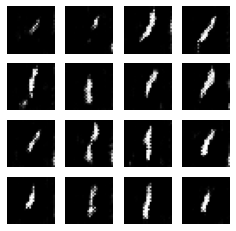

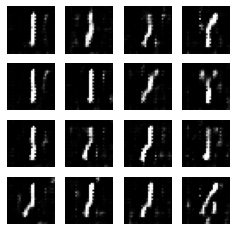

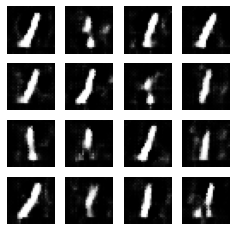

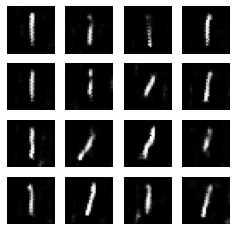

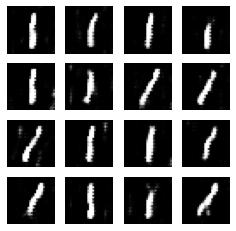

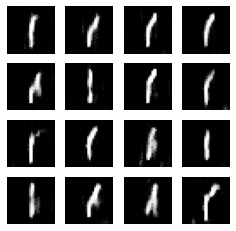

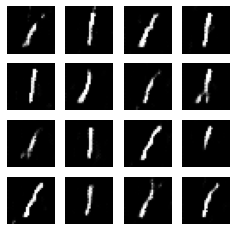

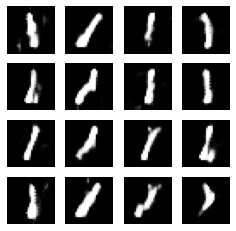

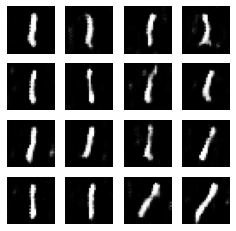

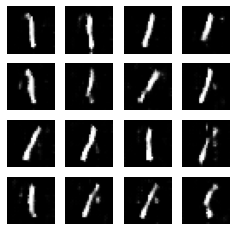

In [40]:
train(iterations, batch_size, sample_interval, normal_data, z_dim)

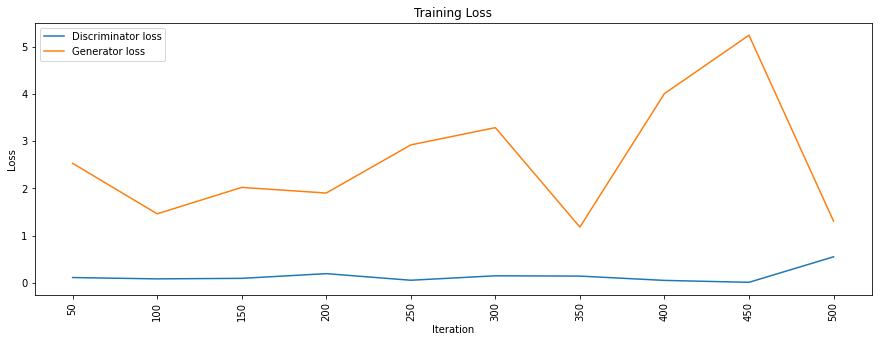

In [41]:
losses = np.array(losses)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

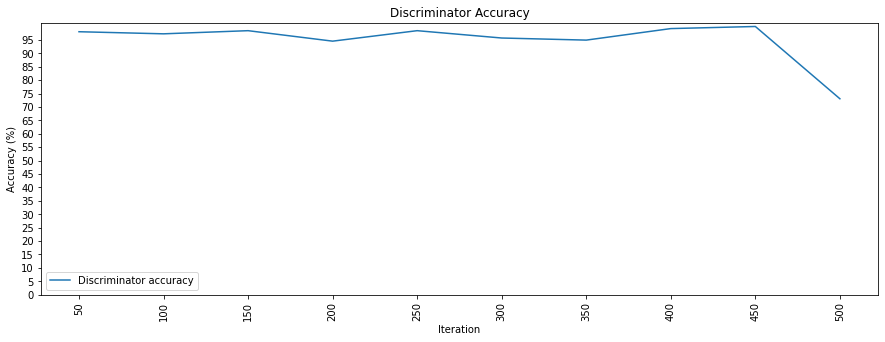

In [42]:
accuracies = np.array(accuracies)

plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy")

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 5))

plt.title("Discriminator Accuracy")
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

In [43]:
generator.save_weights('last_generator.h5', True)
discriminator.save_weights('last_discriminator.h5', True)

In [ ]:
import pandas as pd

In [45]:
acc = pd.DataFrame(accuracies)
acc.index = iteration_checkpoints
acc.to_csv('acc.csv')

In [47]:
loss = pd.DataFrame(accuracies)
loss.index = iteration_checkpoints
loss.to_csv('losses.csv')

[50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

# generate G(z)

In [76]:
def generate(BATCH_SIZE, z_dim):
    g = build_generator(z_dim)
    g.load_weights('last_generator.h5')
    noise = np.random.uniform(0, 1, (BATCH_SIZE, 100))
    generated_images = g.predict(noise)
    return generated_images

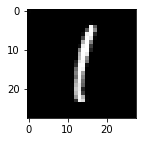

In [77]:
generated_img = generate(1, z_dim)

plt.figure(figsize=(2, 2))
plt.imshow(generated_img[0].reshape(28, 28),cmap=plt.cm.gray)
plt.show()

# train anogan and compute anomaly score

In [78]:
def feature_extractor():
    d = build_discriminator(img_shape)
    d.compile(loss='binary_crossentropy',optimizer=Adam(),metrics=['accuracy'])
    d.load_weights('last_discriminator.h5')
    intermidiate_model = Model(inputs=d.layers[0].input, outputs=d.layers[-5].output)
    intermidiate_model.compile(loss='binary_crossentropy', optimizer='adam')
    return intermidiate_model

In [79]:
def sum_of_residual(y_true, y_pred):
    return tf.reduce_sum(abs(y_true - y_pred))

In [80]:
def compute_anomaly_score(model, x, z_dim):    
    z = np.random.uniform(0, 1, size=(1, z_dim))
    intermidiate_model = feature_extractor()
    d_x = intermidiate_model.predict(x)
    loss = model.fit(z, [x, d_x], epochs=500, verbose=0)
    similar_data, _ = model.predict(z)
    return loss.history['loss'][-1], similar_data

In [81]:
intermidiate = feature_extractor()
intermidiate.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
batch_normalization_13 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 4, 4, 128)         73856     
Total para

In [82]:
def anomaly_detector(z_dim):
    g = build_generator(z_dim)
    g.load_weights('last_generator.h5')
    g.trainable = False
    intermidiate_model = feature_extractor()
    intermidiate_model.trainable = False
    
    aInput = Input(shape=(z_dim,))
    gInput = Dense((z_dim))(aInput)
    G_out = g(gInput)
    D_out= intermidiate_model(G_out)    
    model = Model(inputs=aInput, outputs=[G_out, D_out])
    model.compile(loss=sum_of_residual, loss_weights= [0.9, 0.1], optimizer='adam')
    return model

In [83]:
anoma = anomaly_detector(z_dim)
anoma.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
sequential_10 (Sequential)   (None, 28, 28, 1)         1637121   
_________________________________________________________________
model_2 (Model)              (None, 4, 4, 128)         92928     
Total params: 1,740,149
Trainable params: 10,100
Non-trainable params: 1,730,049
_________________________________________________________________


# Reconfigure the noise to be closer to test_img (abnormal)

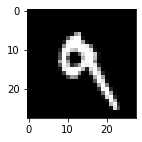

anomaly score : 269.2666015625


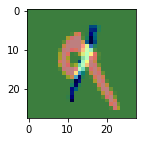

In [84]:
test_img = abnormal_test_data[0]

model = anomaly_detector(z_dim)
ano_score, similar_img = compute_anomaly_score(model, test_img.reshape(1, 28, 28, 1),z_dim)

plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape(28,28), cmap=plt.cm.gray)
plt.show()

print("anomaly score : " + str(ano_score))

plt.figure(figsize=(2, 2))
plt.imshow(test_img.reshape(28,28), cmap=plt.cm.gray)
residual  = test_img.reshape(28,28) - similar_img.reshape(28, 28)
plt.imshow(residual, cmap='jet', alpha=.5)
plt.show()

# Reconfigure the noise to be closer to test_img (normal)

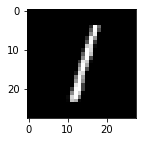

anomaly score : 119.27188873291016


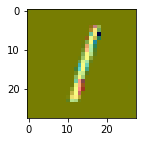

In [85]:
test_img_2 = normal_test_data[0]
model = anomaly_detector(z_dim)
ano_score, similar_img = compute_anomaly_score(model, test_img_2.reshape(1, 28, 28, 1),z_dim)

plt.figure(figsize=(2, 2))
plt.imshow(test_img_2.reshape(28,28), cmap=plt.cm.gray)
plt.show()

print("anomaly score : " + str(ano_score))

plt.figure(figsize=(2, 2))
plt.imshow(test_img_2.reshape(28,28), cmap=plt.cm.gray)
residual  = test_img_2.reshape(28,28) - similar_img.reshape(28, 28)
plt.imshow(residual, cmap='jet', alpha=.5)
plt.show()

Similar reconstruction is possible for normal images.  
However, the abnormal image cannot be reconstructed by using the adjustment term and generator(param freez).  
The difference becomes a score and appears as a color difference on the image.  

# t-SNE embed, visualization

### noize vs normal data

a sample from generated anomaly images(random noise image)


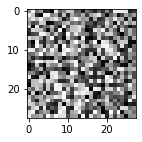

300/300 [==============================] - 0s 173us/step


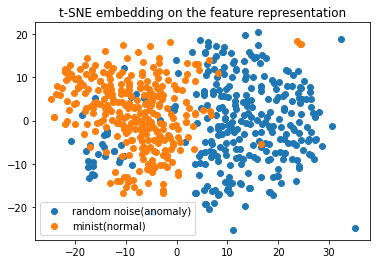

In [86]:
from sklearn.manifold import TSNE

random_image = np.random.uniform(0,1, (300, 28,28, 1))
print("a sample from generated anomaly images(random noise image)")
plt.figure(figsize=(2, 2))
plt.imshow(random_image[0].reshape(28,28), cmap=plt.cm.gray)
plt.show()

model = feature_extractor()
feature_map_of_random = model.predict(random_image, verbose=1)
feature_map_of_minist = model.predict(normal_test_data[:300], verbose=1)

output = np.concatenate((feature_map_of_random, feature_map_of_minist))
output = output.reshape(output.shape[0], -1)
anomaly_flag = np.array([1]*300+ [0]*300)

X_embedded = TSNE(n_components=2).fit_transform(output)
plt.title("t-SNE embedding on the feature representation")
plt.scatter(X_embedded[:300,0], X_embedded[:300,1], label='random noise(anomaly)')
plt.scatter(X_embedded[300:,0], X_embedded[300:,1], label='minist(normal)')
plt.legend()
plt.show()

### normal vs abnormal

normal data


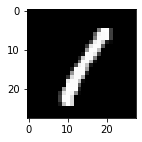

abnormal data


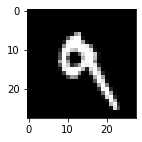

300/300 [==============================] - 0s 236us/step


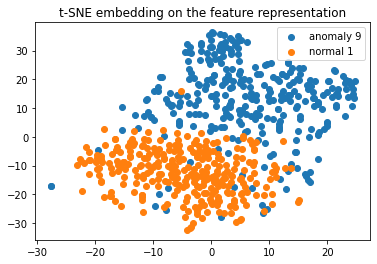

In [88]:
from sklearn.manifold import TSNE

print('normal data')
plt.figure(figsize=(2, 2))
plt.imshow(normal_data[0].reshape(28, 28),cmap=plt.cm.gray)
plt.show()

print('abnormal data')
plt.figure(figsize=(2, 2))
plt.imshow(abnormal_test_data[0].reshape(28, 28),cmap=plt.cm.gray)
plt.show()

model = feature_extractor()
feature_map_of_abnormal = model.predict(abnormal_test_data[:300], verbose=1)
feature_map_of_normal = model.predict(normal_test_data[:300], verbose=1)

output = np.concatenate((feature_map_of_abnormal, feature_map_of_normal))
output = output.reshape(output.shape[0], -1)
anomaly_flag = np.array([1]*300+ [0]*300)
X_embedded = TSNE(n_components=2).fit_transform(output)
plt.title("t-SNE embedding on the feature representation")

plt.scatter(X_embedded[:300,0], X_embedded[:300,1], label='anomaly 9')
plt.scatter(X_embedded[300:,0], X_embedded[300:,1], label='normal 1')
plt.legend()
plt.show()

# Evaluation

In [91]:
normal_test_data.shape[0]
# label 0

1135

In [105]:
abnormal_test_data.shape[0]
# label 1

1009

In [106]:
normal_label = np.zeros((normal_test_data.shape[0], 1))
abnormal_label = np.ones((abnormal_test_data.shape[0], 1))
labels = np.concatenate((normal_label, abnormal_label))

In [107]:
concat_data = np.concatenate((normal_test_data, abnormal_test_data))

In [108]:
ano_score_list =[]

for i in range(0,concat_data.shape[0]):
    pict = concat_data[i]
    model = anomaly_detector(z_dim)
    ano_score, similar_img = compute_anomaly_score(model, pict.reshape(1, 28, 28, 1), z_dim)
    ano_score_list.append(ano_score)

In [109]:
anomaly_score_df = pd.DataFrame()
anomaly_score_df['score'] = ano_score_list
anomaly_score_df['label'] = labels
anomaly_score_df['number'] = anomaly_score_df.index

In [110]:
import seaborn as sns

<AxesSubplot:xlabel='number', ylabel='score'>

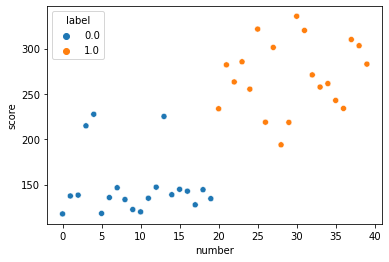

In [111]:
sns.scatterplot(x="number", y="score", hue="label", data=anomaly_score_df)

# define anomaly-line from above score plot

In [112]:
abnormal_line = 200

In [141]:
from sklearn.metrics import confusion_matrix, recall_score, f1_score, precision_score, accuracy_score

def inspect_function(abnormal_line, anomaly_score_df):
    pred_label = np.zeros((len(anomaly_score_df.index), 1))
    #anomaly_score_df['pred'] = pred_label
    pred_label[anomaly_score_df.score > 200] = 1
    
    cm = confusion_matrix(anomaly_score_df['label'], pred_label)
    
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.savefig('heatmap.png')
    
    print('accuracy ' + str(round(accuracy_score(anomaly_score_df['label'], pred_label),2)))
    print('F1 ' + str(round(f1_score(anomaly_score_df['label'], pred_label),2)))
    print('recall ' + str(round(recall_score(anomaly_score_df['label'], pred_label),2)))
    print('precision ' + str(round(precision_score(anomaly_score_df['label'], pred_label),2)))
    
    return anomaly_score_df

accuracy 0.9
F1 0.9
recall 0.95
precision 0.86


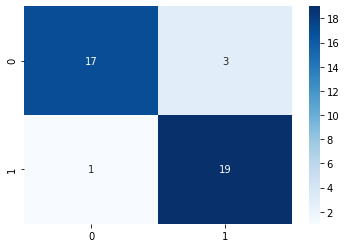

In [142]:
result_df = inspect_function(abnormal_line, anomaly_score_df)

In [143]:
result_df.to_csv('result.csv')